![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Análisis de sentimientos y técnicas de NLP

En este taller podrán poner en práctica sus conocimientos sobre las diferentes técnicas para el procesamiento de lenguaje natural. El taller está constituido por 5 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción sentimientos de viajeros en Twitter

En este taller se usará el conjunto de datos de sentimientos sobre distintas aerolíneas de EE.UU. provenientes de Twitter. Cada observación contiene si el sentimiento de los tweets es positivo, neutral o negativo teniendo en cuenta distintas variables como aerolínea y las razones de los sentimientos negativos (como "retraso en el vuelo" o "servicio grosero"). El objetivo es predecir el sentimiento asociado a cada tweet. Para más detalles pueden visitar el siguiente enlace: [datos](https://www.kaggle.com/crowdflower/twitter-airline-sentiment).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
import nltk
from imblearn.over_sampling import BorderlineSMOTE, SMOTE, ADASYN, SMOTENC, RandomOverSampler
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /Users/yovany/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/yovany/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
# Lectura de la información de archivo .zip
tweets = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/Tweets.zip', index_col=0)

# Visualización dataset
tweets.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,,,,,,,
570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
# Impresión tamaño del cojunto de datos
tweets.shape

(14640, 14)

### Análisis descriptivo

In [5]:
# Cuenta de tweets por cada sentimiento
tweets['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

Para todas las aerolineas, lo más frecuente es encontrar tweets con sentimientos negativos lo que invita a pensar en que la experiencia de usuario negativa es la más publicada en twitter más no necesariamente la que se más se produce en las aerolíneas. Cuando un usuario vive un momento de verdad negativo es de esperar que use estas redes sociales para expresar su sentimiento.

In [6]:
# Cuenta de tweets por cada aerolínea
tweets['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

<AxesSubplot:title={'center':'Sentiminetos por aerolínea'}, xlabel='airline'>

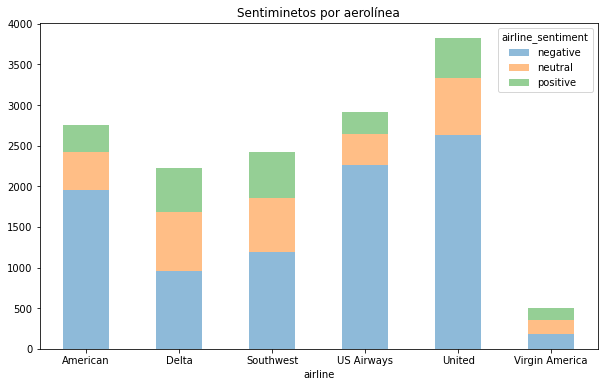

In [7]:
# Plot con cuenta de tweets por cada aerolínea y sentimiento
pd.crosstab(index = tweets["airline"],columns = tweets["airline_sentiment"]).plot(kind='bar',figsize=(10, 6),alpha=0.5,rot=0,stacked=True,title="Sentiminetos por aerolínea")

Estos datos se convierten en un insumo para identificar causas de sentimientos negativos en las aerolíneas dado que se puede observar que las aerolíneas con mayor cantidad de tweets con sentimientos negativos son las que más se mencionan en las redes sociales, aclarando tambien que para que una experiencia se traduzca en un tweet positivo es porque dicha experiencia fue realmente positiva.

### Liberias y Variables de interés y predicción

In [8]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
col=[]
val=[]


In [9]:
# Separación de variables predictoras (X) y de variable de interés (y)
X = tweets['text']
y = tweets['airline_sentiment'].map({'negative':-1,'neutral':0,'positive':1})

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=100000)

X_tfidf = vec.fit_transform(X)

sm = SMOTE(k_neighbors=1, random_state = 2) 
X_tfidf_res, y_res = sm.fit_resample(X_tfidf, y)

In [11]:
# Separación de datos en set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_res, y_res, test_size=0.33, random_state=42)

<AxesSubplot:title={'center':'Sentiminetos por aerolínea'}, xlabel='airline_sentiment'>

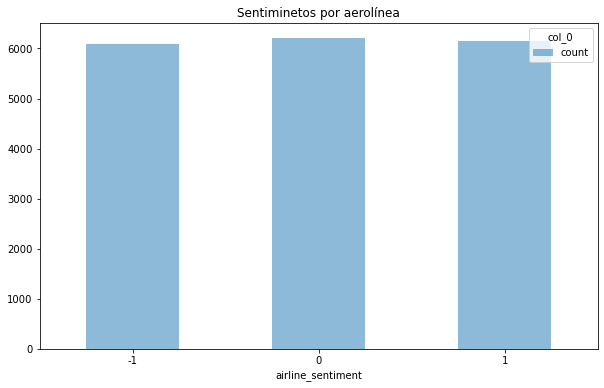

In [12]:
pd.crosstab(index = y_train,columns = 'count').plot(kind='bar',figsize=(10, 6),alpha=0.5,rot=0,stacked=True,title="Sentiminetos por aerolínea")

### Punto 1 - Uso de CountVectorizer

En la celda 1 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [13]:
classifier = RandomForestClassifier(n_estimators=100, random_state=0)
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)
col.append('TfidfVectorizer')
val.append( float(round(metrics.accuracy_score(y_test, predictions),4)))

In [14]:
print ("RandomForestClassifier, WordLevel TFIDF")
print("Accuracy:",metrics.accuracy_score(y_test, predictions))
print("F1 score:",metrics.f1_score(y_test,predictions,average='micro'))

RandomForestClassifier, WordLevel TFIDF
Accuracy: 0.90073731704633
F1 score: 0.90073731704633


In [15]:
X_train = vec.inverse_transform(X_train)
X_test  = vec.inverse_transform(X_test)

In [16]:
X_train_re=[]
for i in range(len(X_train)):
    X_train_re.append(' '.join(X_train[i]))

X_test_re=[]
for i in range(len(X_test)):
    X_test_re.append(' '.join(X_test[i]))

In [17]:
vect_A= CountVectorizer(lowercase=False,encoding='utf-8')

X_Train_A = vect_A.fit_transform(X_train_re)
X_Test_A  = vect_A.transform(X_test_re)

rfc = RandomForestClassifier(n_estimators=100, random_state=0)
rfc.fit(X_Train_A,y_train)
predict=rfc.predict(X_Test_A)
col.append('CountVectorizer')
val.append( float(round(metrics.accuracy_score(y_test, predict),4)))

In [18]:
print ("CountVectorizer")
print("Accuracy:",metrics.accuracy_score(y_test, predict))
print("F1 score:",metrics.f1_score(y_test,predictions,average='micro'))
print(metrics.confusion_matrix(y_test, predict))

CountVectorizer
Accuracy: 0.9191152195444041
F1 score: 0.90073731704633
[[2813  202   77]
 [ 228 2678   69]
 [  90   69 2861]]


Al utilizar el CountVectorizer obtenemos un Accuracy de 0.7737996688741722

### Punto 2 - Eliminación de Stopwords

En la celda 2 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer, **eliminen stopwords** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [19]:
# Celda 1
vect_B = CountVectorizer(lowercase=False,encoding='utf-8',stop_words='english')

X_Train_B = vect_B.fit_transform(X_train_re)
X_Test_B=vect_B.transform(X_test_re)

rfc = RandomForestClassifier(n_estimators=100, random_state=0)
rfc.fit(X_Train_B,y_train)
predict=rfc.predict(X_Test_B)
col.append('Stopwords')
val.append( float(round(metrics.accuracy_score(y_test, predict),4)))

print ("CountVectorizer StopWord")
print("Accuracy:",metrics.accuracy_score(y_test, predict))
print("F1 score:",metrics.f1_score(y_test,predictions,average='micro'))
print(metrics.confusion_matrix(y_test, predict))

CountVectorizer StopWord
Accuracy: 0.892813909981292
F1 score: 0.90073731704633
[[2539  420  133]
 [ 171 2707   97]
 [  68   85 2867]]


Al eliminar las stopwords obtenemos un Accuracy de 0.761796357615894, es decir perdemos in 1% de accuracy respecto al modelo anterior, pero consideramos que esto se debe al desbalanceo de los datos ya que acá aunque perdemos capacidad predictiva para las opiniones negativas, ganamos poder predictivo para identificar las opiniones positivas y neutrales.

### Punto 3 - Lematización con verbos

En la celda 3 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer, **lematizen el texto con verbos** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [20]:
# Definición de la función que tenga como parámetro texto y devuelva una lista de lemas
def split_into_lemmas_verbs(text):
    text = text.lower()
    words = text.split()
    return [wordnet_lemmatizer.lemmatize(word,pos='v') for word in words]

In [21]:
# Desempeño del modelo al lematizar el texto
vect_lemas_verbs = CountVectorizer(analyzer=split_into_lemmas_verbs)

X_Train_C = vect_lemas_verbs.fit_transform(X_train_re)
X_Test_C = vect_lemas_verbs.transform(X_test_re)

rfc = RandomForestClassifier(n_estimators=100, random_state=0)
rfc.fit(X_Train_C,y_train)
predict=rfc.predict(X_Test_C)
col.append('Lematización')
val.append( float(round(metrics.accuracy_score(y_test, predict),4)))

print ("Lematización")
print("Accuracy:",metrics.accuracy_score(y_test, predict))
print("F1 score:",metrics.f1_score(y_test,predictions,average='micro'))
print(metrics.confusion_matrix(y_test, predict))

Lematización
Accuracy: 0.9228568284362276
F1 score: 0.90073731704633
[[2841  187   64]
 [ 220 2680   75]
 [  88   67 2865]]


Este caso se parece más al orginal en el que usabamos el countvectorizer para el preprocesamiento de los datos, pero en este caso  perdemos poco más de 1% de accuracy respecto a dicho modelo y no pareciera mejorar la detección de opiniones positivas y neutrales.

### Punto 4 - Multiples técnicas

En la celda 4 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer, eliminen stopwords, lematizen el texto con verbos** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [22]:
# Celda 4
vect_lemas_verbs_B = CountVectorizer(stop_words='english',analyzer=split_into_lemmas_verbs)

X_Train_D = vect_lemas_verbs_B.fit_transform(X_train_re)
X_Test_D = vect_lemas_verbs_B.transform(X_test_re)

rfc = RandomForestClassifier(n_estimators=100, random_state=0)
rfc.fit(X_Train_D,y_train)
predict=rfc.predict(X_Test_D)
col.append('Multiple Técnicas')
val.append( float(round(metrics.accuracy_score(y_test, predict),4)))
print("Accuracy:",metrics.accuracy_score(y_test, predict))
print("F1 score:",metrics.f1_score(y_test,predictions,average='micro'))
print(metrics.confusion_matrix(y_test, predict))

Accuracy: 0.9228568284362276
F1 score: 0.90073731704633
[[2841  187   64]
 [ 220 2680   75]
 [  88   67 2865]]


### Punto 5 - Comparación y análisis de resultados

En la celda 5 comparen los resultados obtenidos de los diferentes modelos (random forest) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

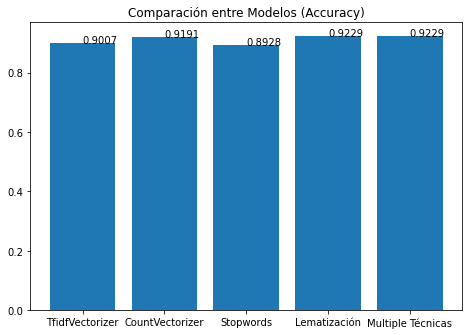

In [23]:
# Celda 5
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación entre Modelos (Accuracy)")
ax.bar(col,val)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(col,val,plt)
plt.show()

Al comparar los distintos modelos obtenidos, podemos observar que el modelo con el mejor desempeño es el modelo  original sin lematizar el texto con verbos, sin eliminar stopwords, pero el modelo con mayor capacidad de identificar correctamente las opiniones positivas y neutrales es el modelo dodne eliminamos las stopwords.